In [3]:
# Install the required packages
!pip install -r requirements.txt

  Using cached matplotlib-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl (7.2 MB)
  Using cached fonttools-4.55.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (324 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)


In [61]:
# Import the required libraries
import math
import os
import time
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import torch
import tyro
from PIL import Image
from torch import Tensor, optim

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from gsplat import rasterization, rasterization_2dgs

In [52]:
class GaussianImageTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
    ) -> None:
        """
        Initializes the GaussianImageTrainer.

        Args:
        - gt_image: Tensor, the ground truth image to fit
        - num_points: int, the number of gaussians to use

        Returns:
        - None
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)

        self._init_gaussians()

    def _init_gaussians(self):
        """
        Initializes random gaussians for the optimization.
        Modifies / learns the following attributes:
        - self.means: Mean values of the gaussians
        - self.scales: Scales of the gaussians
        - self.quats: Quaternions or rotations of the gaussians
        - self.rgbs: Colors (RGB) of the gaussians
        - self.opacities: Opacities of the gaussians
        - self.viewmat: View matrix (camera view position)

        Args:
        - None

        Returns:
        - None
        """
        # Bounding box size
        bd = 2

        # Randomly initialize the means and center them around the image
        self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)

        # Randomly initialize the scales
        self.scales = torch.rand(self.num_points, 3, device=self.device)

        # Randomly initialize the RGB colors (3 color channels)
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        # Randomly initialize the quaternions (4 rotation values)
        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)
        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )
        self.quats = self.quats / self.quats.norm(dim=-1, keepdim=True)

        # Randomly initialize the opacities
        self.opacities = torch.ones((self.num_points), device=self.device)

        # Initialize the view matrix (camera view position)
        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )

        # Initialize the background color
        self.background = torch.zeros(d, device=self.device)

        # Learn the following parameters
        self.means.requires_grad = True
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        model_type: Literal["3dgs", "2dgs"] = "3dgs",
    ) -> None:
        """
        Trains the random gaussians to fit the ground truth image.

        Args:
        - iterations: int, the number of iterations to train
        - lr: float, the learning rate
        - save_imgs: bool, whether to save the images
        - model_type: Literal["3dgs", "2dgs"], the model type to use, where
            "3dgs" uses 3D gaussians and "2dgs" uses 2D gaussians

        Returns:
        - None
        """
        # Initialize the Adam optimizer and the MSE loss function
        optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        mse_loss = torch.nn.MSELoss()

        # Initialize the frames for saving the images
        frames = []

        # Initialize the times for rasterization and backward pass
        times = [0] * 2  # (rasterization, backward)

        # Initialize the camera intrinsics matrix
        K = torch.tensor(
            [
                [self.focal, 0, self.W / 2],
                [0, self.focal, self.H / 2],
                [0, 0, 1],
            ],
            device=self.device,
        )

        # Select the rasterization function based on the model type
        # Docs: https://docs.gsplat.studio/main/apis/rasterization.html
        if model_type == "3dgs":
            rasterize_fnc = rasterization
        elif model_type == "2dgs":
            rasterize_fnc = rasterization_2dgs
        else:
            raise ValueError("Unsupported model type: {model_type}")

        # Iterate
        for iter in range(iterations):
            start = time.time()

            # Rasterize the gaussians
            renders = rasterize_fnc(
                self.means,
                self.quats / self.quats.norm(dim=-1, keepdim=True),
                self.scales,
                torch.sigmoid(self.opacities),
                torch.sigmoid(self.rgbs),
                self.viewmat[None],
                K[None],
                self.W,
                self.H,
                packed=False,
            )[0]
            out_img = renders[0]
            torch.cuda.synchronize()
            times[0] += time.time() - start

            # Compute the loss and optimize
            loss = mse_loss(out_img, self.gt_image)
            optimizer.zero_grad()
            start = time.time()
            loss.backward()
            torch.cuda.synchronize()
            times[1] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}")

            # Save the images
            if save_imgs and iter % 5 == 0:
                frames.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))

        # Save the images as a gif
        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame) for frame in frames]
            out_dir = Path.cwd() / "results"
            out_dir.mkdir(parents=True, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(f"Final loss: {loss.item()}")
        print(f"Total(s):\nRasterization: {times[0]:.3f}, Backward: {times[1]:.3f}")
        print(
            f"Per step(s):\nRasterization: {times[0]/iterations:.5f}, Backward: {times[1]/iterations:.5f}"
        )

In [10]:
def train(
    height: int = 32,
    width: int = 32,
    num_points: int = 1024,
    save_imgs: bool = True,
    img: Optional[torch.Tensor] = None,
    img_path: Optional[Path] = None,
    iterations: int = 1000,
    lr: float = 0.01,
    model_type: Literal["3dgs", "2dgs"] = "3dgs",
) -> None:
    """
    Trains random Gaussians to fit an image.

    Args:
    - height: int, the height of the image
    - width: int, the width of the image
    - num_points: int, the number of gaussians to use
    - save_imgs: bool, whether to save the images
    - img: Optional[Tensor], the image tensor to fit
    - img_path: Optional[Path], the path to the image to fit
    - iterations: int, the number of iterations to train
    - lr: float, the learning rate
    - model_type: Literal["3dgs", "2dgs"], the model type to use, where
        "3dgs" uses 3D gaussians and "2dgs" uses 2D gaussians

    Returns:
    - None
    """
    # Load or create the ground truth image
    if img is not None:
        gt_image = img
    elif img_path is not None:
        gt_image = image_path_to_tensor(img_path)
    else:
        gt_image = create_default_image(height=height, width=width)

    # Ensure the image is in the correct format (e.g., normalized or device-assigned)
    gt_image = preprocess_image(gt_image)

    # Initialize the trainer
    trainer = GaussianImageTrainer(gt_image=gt_image, num_points=num_points)

    # Train the model
    try:
        trainer.train(
            iterations=iterations,
            lr=lr,
            save_imgs=save_imgs,
            model_type=model_type,
        )
    except Exception as e:
        print(f"Training failed due to: {e}")
        raise

In [48]:
dataloader = load_cifar10(batch_size=1, shuffle=False, train=True)

Files already downloaded and verified


In [49]:
image, _ = next(iter(dataloader))
image[0].shape

torch.Size([32, 32, 3])

In [53]:
train(
    height=32,
    width=32,
    num_points=1024,
    save_imgs=True,
    img=image[0],
    iterations=1000,
    lr=0.01,
    model_type="3dgs",
)

Iteration 1/1000, Loss: 0.22380398213863373
Iteration 2/1000, Loss: 0.22074919939041138
Iteration 3/1000, Loss: 0.2180129587650299
Iteration 4/1000, Loss: 0.21542024612426758
Iteration 5/1000, Loss: 0.21301023662090302
Iteration 6/1000, Loss: 0.21074311435222626
Iteration 7/1000, Loss: 0.2087288200855255
Iteration 8/1000, Loss: 0.2068854570388794
Iteration 9/1000, Loss: 0.20513324439525604
Iteration 10/1000, Loss: 0.2035561501979828
Iteration 11/1000, Loss: 0.20203635096549988
Iteration 12/1000, Loss: 0.20064406096935272
Iteration 13/1000, Loss: 0.19934754073619843
Iteration 14/1000, Loss: 0.19815662503242493
Iteration 15/1000, Loss: 0.1969626396894455
Iteration 16/1000, Loss: 0.19580698013305664
Iteration 17/1000, Loss: 0.19467684626579285
Iteration 18/1000, Loss: 0.1935456246137619
Iteration 19/1000, Loss: 0.1926092803478241
Iteration 20/1000, Loss: 0.19166120886802673
Iteration 21/1000, Loss: 0.19079375267028809
Iteration 22/1000, Loss: 0.18998365104198456
Iteration 23/1000, Loss: 0

In [78]:
def visualize_tensor(tensor: torch.Tensor) -> None:
    """
    Visualizes the tensor using PIL.

    Args:
    - tensor: Tensor, the tensor to visualize

    Returns:
    - None
    """
    print(tensor.shape)
    tensor = tensor.permute(2, 1, 0)
    print(tensor.shape)
    tensor = tensor.detach().cpu().numpy()
    tensor = (tensor * 255).astype(np.uint8)
    img = Image.fromarray(tensor)
    img.show()

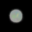

torch.Size([32, 32, 3])
torch.Size([3, 32, 32])


TypeError: Cannot handle this data type: (1, 1, 32), |u1

In [79]:
visualize_gif("results/training.gif")
visualize_tensor(image[0])

In [ ]:
# Create me Path
path = Path("results")

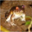

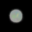

In [90]:
from torchvision import transforms
from PIL import Image
import torch


def visualize_tensor(tensor: torch.Tensor) -> None:
    """
    Reverses the tensor transformation and visualizes the image as a PIL image.

    Args:
    - tensor (torch.Tensor): The input tensor with shape (H, W, C) normalized between [-1, 1].

    Returns:
    - None
    """
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a torch.Tensor.")
    if len(tensor.shape) != 3 or tensor.shape[-1] != 3:
        raise ValueError(
            "Input tensor must have shape (H, W, C) with 3 color channels."
        )

    # Reverse the normalization and permute back to (C, H, W)
    inverse_transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x.permute(2, 0, 1)),  # Back to (C, H, W)
            transforms.Normalize(
                (-1.0, -1.0, -1.0), (2.0, 2.0, 2.0)
            ),  # Reverse normalization
            transforms.ToPILImage(),  # Convert to PIL
        ]
    )

    # Apply the inverse transform
    pil_image = inverse_transform(tensor)

    # Display the image
    pil_image.show()


visualize_tensor(image[0])
visualize_gif("results/training.gif")

In [2]:
from utils.data import collect_class_images
from utils import load_cifar10

# Load CIFAR-10 training data
dataloader = load_cifar10(batch_size=32, shuffle=False, train=True)

# Collect 5 images for each class
N = 5
class_images = collect_class_images(dataloader, N)

# Print the class-to-index mapping and collected images
print(f"Class to index mapping: {dataloader.dataset.class_to_idx}")
for class_name, images in class_images.items():
    print(f"Class {class_name}: Collected {len(images)} images")

class_images

Files already downloaded and verified
Class to index mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Class airplane: Collected 5 images
Class automobile: Collected 5 images
Class bird: Collected 5 images
Class cat: Collected 5 images
Class deer: Collected 5 images
Class dog: Collected 5 images
Class frog: Collected 5 images
Class horse: Collected 5 images
Class ship: Collected 5 images
Class truck: Collected 5 images


{'airplane': [tensor([[[0.7922, 0.8000, 0.7804],
           [0.7922, 0.8000, 0.7804],
           [0.8000, 0.8078, 0.7882],
           ...,
           [0.8118, 0.8157, 0.7843],
           [0.8039, 0.8078, 0.7804],
           [0.7961, 0.8000, 0.7765]],
  
          [[0.8078, 0.8157, 0.7961],
           [0.8078, 0.8157, 0.7961],
           [0.8118, 0.8196, 0.8000],
           ...,
           [0.8235, 0.8275, 0.8039],
           [0.8157, 0.8196, 0.7961],
           [0.8078, 0.8118, 0.7882]],
  
          [[0.8235, 0.8314, 0.8118],
           [0.8275, 0.8353, 0.8157],
           [0.8314, 0.8392, 0.8235],
           ...,
           [0.8392, 0.8392, 0.8235],
           [0.8314, 0.8353, 0.8157],
           [0.8235, 0.8275, 0.8078]],
  
          ...,
  
          [[0.8549, 0.8510, 0.8706],
           [0.8235, 0.8196, 0.8392],
           [0.7608, 0.7608, 0.7765],
           ...,
           [0.9529, 0.9490, 0.9686],
           [0.9569, 0.9490, 0.9686],
           [0.9529, 0.9529, 0.9686]],
  
  